<a href="https://colab.research.google.com/github/jihunyuk/Any/blob/main/CVDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conplex Valued Deep Neural Network**
# **Hyperparameters**
---
>**Parameter initialization : weight and bias**
---
>**Loss function: ComplexRMSELoss**
---
>**batch size: 18**
---
>**Number of epochs: 6000**
---
>**Number of hidden layers: 2**
---
>**Regularization term parameter: ?**
---
>**Optimization algorithm: Adam**
---
>**learning rate: 0.01**




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import easydict
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.signal import butter, filtfilt, find_peaks
from scipy import signal
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import *
from random import shuffle
from tqdm.notebook import trange, tqdm
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive


In [ ]:
timesteps = 375
sampling_frequency = 250
batch_size = 100

In [ ]:
def cal_fft(x):
    N = 375  # 샘플링 개수
    fs = 250  # 샘플링 주파수
    time = np.arange(N)/fs # 시간

    # FFT 계산
    fft_result = np.fft.fft(x)[:N//2]

    # array 생성
    fft_array = np.zeros(36, dtype=np.complex)

    for i in range(36):
        fft_array[i] = fft_result[i]

    # 6x6 행렬 생성
    fft_matrix = fft_array.reshape(6, 6)

    return fft_matrix

In [ ]:
def cal_ifft(fft_matrix):
    fft_array = fft_matrix.reshape(-1)  # 6x6 행렬을 36개의 복소수 값을 가지는 배열로 변환

    N = 375  # 샘플링 개수
    fs = 250  # 샘플링 주파수

    # IFFT 계산을 위한 배열 생성
    ifft_result = np.zeros(N, dtype=np.complex)

    for i in range(36):
        ifft_result[i] = fft_array[i]

    # IFFT 계산
    ifft_result = np.fft.ifft(ifft_result).real.round(3)
    ifft_result = ifft_result - np.min(ifft_result)
    ifft_result = ifft_result / np.max(ifft_result)

    return ifft_result

In [ ]:
# -------------------------------------------- load input data & pre-processing -------------------------------------------- #
df_i = []

list_p = [22]
for i in list_p:
    PPG_data_path = '/content/gdrive/MyDrive/ppg_data/' + str(i) + '/ppg_' + str(i) + '_' + '250' + 'g.txt'

    PPG_data = pd.read_csv(PPG_data_path)
    PPG_data = pd.DataFrame(PPG_data.iloc[10000:47500,1])/1000
    PPG_data = np.array(PPG_data).reshape(-1)
    df_i.append(PPG_data)

df_i = np.array(df_i)

PPG_data_i = df_i.reshape(-1,1)

print(PPG_data_i.shape)

print(len(PPG_data_i))
print('The shape of the original dataset is %i by %i' % np.shape(PPG_data_i))

(37500, 1)
37500
The shape of the original dataset is 37500 by 1


[0.79032258 0.75806452 0.77419355 0.72580645 0.77419355 0.70967742
 0.75806452 0.70967742 0.75806452 0.70967742 0.72580645 0.69354839
 0.72580645 0.69354839 0.70967742 0.67741935 0.69354839 0.67741935
 0.67741935 0.66129032 0.66129032 0.66129032 0.62903226 0.66129032
 0.61290323 0.64516129 0.61290323 0.64516129 0.59677419 0.66129032
 0.61290323 0.66129032 0.61290323 0.66129032 0.62903226 0.67741935
 0.66129032 0.67741935 0.67741935 0.69354839 0.69354839 0.72580645
 0.72580645 0.72580645 0.72580645 0.72580645 0.74193548 0.72580645
 0.75806452 0.72580645 0.77419355 0.74193548 0.79032258 0.75806452
 0.82258065 0.77419355 0.85483871 0.83870968 0.90322581 0.87096774
 0.91935484 0.87096774 0.91935484 0.88709677 0.88709677 0.85483871
 0.85483871 0.80645161 0.77419355 0.75806452 0.70967742 0.67741935
 0.61290323 0.58064516 0.5        0.48387097 0.38709677 0.40322581
 0.30645161 0.32258065 0.25806452 0.27419355 0.19354839 0.22580645
 0.17741935 0.20967742 0.17741935 0.19354839 0.17741935 0.2096

<ipython-input-4-7fd60811c3f8>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)
<ipython-input-5-60bebde44bf5>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

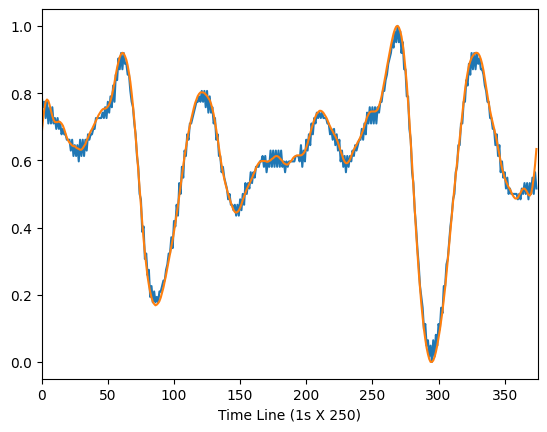

In [ ]:
sample = PPG_data_i[0:375,0]
sample = sample - np.min(sample)
sample = sample / np.max(sample)
print(sample)
plt.xlim(0,375)
plt.xlabel('Time Line (1s X 250)')
plt.plot(sample)
print(cal_fft(sample))
print(cal_ifft(cal_fft(sample)))
plt.xlim(0,375)
plt.plot(cal_ifft(cal_fft(sample)))
plt.show

In [ ]:
# -------------------------------------------- load target data & pre-processing -------------------------------------------- #
df_t = []

list_p = [22]
for i in list_p:
    PPG_data_path = '/content/gdrive/MyDrive/ppg_data/' + str(i) + '/ppg_' + str(i) + '_' + '250' + 'g.txt'

    PPG_data = pd.read_csv(PPG_data_path)
    PPG_data = pd.DataFrame(PPG_data.iloc[10000:47500,2])/1000
    PPG_data = np.array(PPG_data).reshape(-1)
    df_t.append(PPG_data)

df_t = np.array(df_t)

PPG_data_t = df_t.reshape(-1,1)

print(PPG_data_t.shape)

print(len(PPG_data_t))
print('The shape of the original dataset is %i by %i' % np.shape(PPG_data_t))

(37500, 1)
37500
The shape of the original dataset is 37500 by 1


[[ 1.93042000e+02+0.j          4.09207601e-02+0.14651762j
   6.64054267e-01-0.76648741j  5.44322995e-01+0.02088327j
  -1.19760988e+00+0.39080878j -1.55567378e+00+0.35742381j]
 [ 8.52866298e-01-0.95087898j  1.44662111e+00-1.00689217j
  -1.51995084e-01+0.20576122j -2.62394085e-01+0.18778753j
  -1.59327644e-01-0.11403948j  3.24450807e-01-0.03612836j]
 [ 1.49310263e-01+0.02425299j -2.16093316e-01-0.24106378j
  -3.67346927e-03-0.14889485j  1.84123591e-03+0.0302344j
   3.35397771e-03+0.04826655j  5.09907722e-02-0.0527764j ]
 [ 4.50566258e-02-0.06332168j -4.38758682e-03-0.03670718j
   8.11989295e-03-0.05389244j -2.71283624e-03-0.04367939j
  -5.53906445e-03-0.0607125j   2.16992852e-02-0.0177252j ]
 [ 1.66607524e-02-0.04338699j  1.84686592e-02-0.01756543j
   1.32633269e-02-0.05213726j  3.89562439e-02-0.031745j
  -1.02738596e-02-0.03492665j  1.50654595e-02-0.02979708j]
 [ 6.65305590e-03-0.02148334j  6.91621874e-05-0.00369673j
   1.94048965e-02-0.04556507j -5.04140817e-06-0.0280051j
   8.26773303

<ipython-input-4-7fd60811c3f8>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)
<ipython-input-5-60bebde44bf5>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

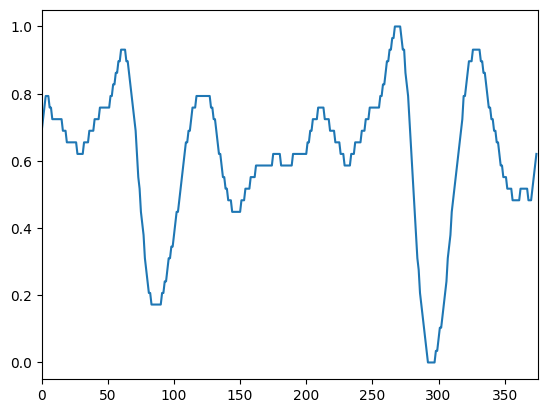

In [ ]:
print(cal_fft(PPG_data_i[0:375,0]))
plt.xlim(0,375)
plt.plot(cal_ifft(cal_fft(PPG_data_i[0:375,0])))
plt.show

[[ 2.11871000e+02 +0.j          4.03206225e+00 +0.21710849j
  -2.52255240e+01 -1.18584837j -7.47407398e+00 -8.20880192j
   1.70515000e+01+13.2025634j   1.09294612e+01 +9.5630692j ]
 [-8.20675873e+00 -2.83928371j -3.29382861e+00 -3.85393236j
  -3.70266354e-01 +1.82737491j -1.29082507e+00 +2.87713429j
  -3.72108599e-01 +0.15501946j  4.71199224e-01 +0.11040842j]
 [-3.55446131e-01 +0.37145492j -3.03662069e-01 +0.04786952j
   6.39310726e-03 +0.15392631j -1.12706860e-01 +0.46450424j
  -3.25895181e-01 +0.20675942j -7.98929887e-02 +0.04576976j]
 [-1.40531244e-02 +0.23028806j -8.76328623e-02 +0.30183271j
  -2.02682352e-01 +0.17624814j -8.57892638e-02 +0.04469105j
   5.45185523e-02 +0.14730631j -7.34618071e-02 +0.25722838j]
 [-1.84910382e-01 +0.1524672j  -7.17673775e-02 +0.01632954j
   3.67685873e-02 +0.15673957j -7.18299414e-02 +0.23611524j
  -1.48521986e-01 +0.10517949j -6.35272926e-02 +0.02262892j]
 [ 2.56902308e-02 +0.12822488j -7.63962148e-02 +0.20615806j
  -1.22478285e-01 +0.09651394j -3.9

<ipython-input-4-7fd60811c3f8>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)
<ipython-input-5-60bebde44bf5>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

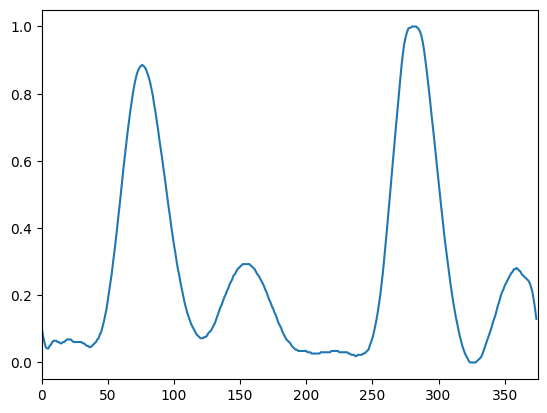

In [ ]:
print(cal_fft(PPG_data_t[0:375,0]))
plt.xlim(0,375)
plt.plot(cal_ifft(cal_fft(PPG_data_t[0:375,0])))
plt.show

In [ ]:
input_data = []
for i in range(100):
  input_data.append(cal_fft(PPG_data_i[375*i:375*i+375,0]))

input_data = torch.tensor(input_data)
print(input_data.shape)

target_data = []
for i in range(100):
  target_data.append(cal_fft(PPG_data_t[375*i:375*i+375,0]))

target_data = torch.tensor(target_data)
print(target_data.shape)

torch.Size([100, 6, 6])
torch.Size([100, 6, 6])


<ipython-input-4-7fd60811c3f8>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)
<ipython-input-11-357decaa14cd>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_data = torch.tensor(input_data)


In [ ]:
# 손실 함수 정의
class ComplexRMSELoss(nn.Module): #RME
    def __init__(self):
        super(ComplexRMSELoss, self).__init__()

    def forward(self, input, target):
        real_loss = torch.mean(torch.square(input.real - target.real))
        imag_loss = torch.mean(torch.square(input.imag - target.imag))
        loss = torch.sqrt((real_loss * real_loss + imag_loss * imag_loss)/2)/1000
        return loss

# 모델 정의
class CVDNN(nn.Module):
    def __init__(self):
        super(CVDNN, self).__init__()
        self.fc_real = nn.Linear(6, 10)
        self.fc_imag = nn.Linear(6, 10)
        self.fc_hidden1 = nn.Linear(10, 100)
        self.fc_hidden2 = nn.Linear(100, 10)
        self.fc_out_real = nn.Linear(10, 6)
        self.fc_out_imag = nn.Linear(10, 6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_real = self.fc_real(x.real.double())
        x_real = self.relu(x_real)
        x_real = self.fc_hidden1(x_real)
        x_real = self.relu(x_real)
        x_real = self.fc_hidden2(x_real)
        x_real = self.relu(x_real)
        x_real = self.fc_out_real(x_real)

        x_imag = self.fc_imag(x.imag.double())
        x_imag = self.relu(x_imag)
        x_imag = self.fc_hidden1(x_imag)
        x_imag = self.relu(x_imag)
        x_imag = self.fc_hidden2(x_imag)
        x_imag = self.relu(x_imag)
        x_imag = self.fc_out_imag(x_imag)

        x = torch.complex(x_real, x_imag)

        return x

# 모델 생성
model = CVDNN()
model = model.double()

# 손실 함수 및 최적화
criterion = ComplexRMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# best evaluation 시점의 체크포인트 모델 불러오기기
#model = torch.load('/content/gdrive/MyDrive/checkpoint/checkpoint_best_CVDNN.pt')

# 학습
epochs = 6000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward 단계
    output = model(input_data.unsqueeze(0))
    loss = criterion(output, target_data)

    # Backward 단계
    loss.backward()

    # 매개변수 업데이트
    optimizer.step()
    best_loss = 100000000

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            # best evaluation 시점의 체크포인트 드라이브에 저장
            torch.save(model, '/content/gdrive/MyDrive/checkpoint/checkpoint_best_CVDNN.pt')


# 테스트
test_output = model(input_data.unsqueeze(0))
print("Input Data:")
print(input_data.shape)
print("Predicted Output:")
print(test_output.squeeze().shape)
print("Target Output:")
print(target_data.shape)

Epoch [100/6000], Loss: 0.050741969632366046
Epoch [200/6000], Loss: 0.04266968554976859
Epoch [300/6000], Loss: 0.03991278617253593
Epoch [400/6000], Loss: 0.03867505950196095
Epoch [500/6000], Loss: 0.03806213885036712
Epoch [600/6000], Loss: 0.037646799300064954
Epoch [700/6000], Loss: 0.03708380911739776
Epoch [800/6000], Loss: 0.03678130289633898
Epoch [900/6000], Loss: 0.036538273385288124
Epoch [1000/6000], Loss: 0.03629733606965831
Epoch [1100/6000], Loss: 0.036121176729069365
Epoch [1200/6000], Loss: 0.03621915496798945
Epoch [1300/6000], Loss: 0.03600772259306858
Epoch [1400/6000], Loss: 0.03590426448745296
Epoch [1500/6000], Loss: 0.03580300634039822
Epoch [1600/6000], Loss: 0.03579981109288745
Epoch [1700/6000], Loss: 0.035390741255766224
Epoch [1800/6000], Loss: 0.03530181707819834
Epoch [1900/6000], Loss: 0.035082645830685565
Epoch [2000/6000], Loss: 0.03507235765858437
Epoch [2100/6000], Loss: 0.0351512749383584
Epoch [2200/6000], Loss: 0.03478577474813183
Epoch [2300/60

Test Input Data:
tensor([[ 1.9304e+02+0.0000j,  4.0921e-02+0.1465j,  6.6405e-01-0.7665j,
          5.4432e-01+0.0209j, -1.1976e+00+0.3908j, -1.5557e+00+0.3574j],
        [ 8.5287e-01-0.9509j,  1.4466e+00-1.0069j, -1.5200e-01+0.2058j,
         -2.6239e-01+0.1878j, -1.5933e-01-0.1140j,  3.2445e-01-0.0361j],
        [ 1.4931e-01+0.0243j, -2.1609e-01-0.2411j, -3.6735e-03-0.1489j,
          1.8412e-03+0.0302j,  3.3540e-03+0.0483j,  5.0991e-02-0.0528j],
        [ 4.5057e-02-0.0633j, -4.3876e-03-0.0367j,  8.1199e-03-0.0539j,
         -2.7128e-03-0.0437j, -5.5391e-03-0.0607j,  2.1699e-02-0.0177j],
        [ 1.6661e-02-0.0434j,  1.8469e-02-0.0176j,  1.3263e-02-0.0521j,
          3.8956e-02-0.0317j, -1.0274e-02-0.0349j,  1.5065e-02-0.0298j],
        [ 6.6531e-03-0.0215j,  6.9162e-05-0.0037j,  1.9405e-02-0.0456j,
         -5.0414e-06-0.0280j,  8.2677e-03-0.0338j,  2.1325e-02-0.0250j]])
Predicted Output:
tensor([[ 1.9240e+02+8.7724e-01j, -1.3057e+00+5.5336e-01j,
         -2.8557e+01-2.7374e+00j, -

<ipython-input-4-60bebde44bf5>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)
<ipython-input-3-7fd60811c3f8>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

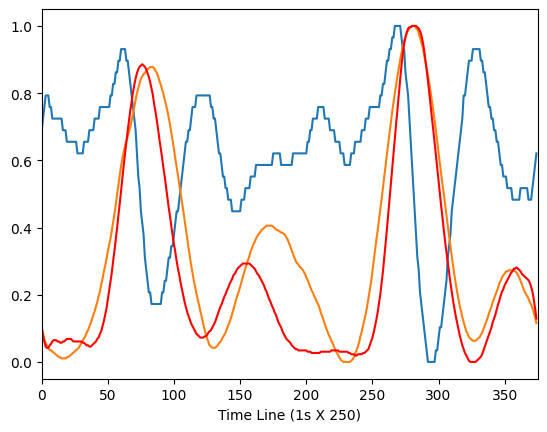

In [ ]:
# 테스트 데이터 정의
# test_input_data = torch.tensor([[1.95042254e+02+0.00000000e+00j, 5.97306187e+00-3.48665761e+00j, -4.15126506e+01-2.80030217e+01j, -2.59997402e+00-2.29221227e+00j, 1.50438737e+01+4.80248839e+01j, 3.21887044e-01+1.13902351e+01j],
#                                 [-1.97832436e+01-1.66325740e+01j, 4.26903799e-01-8.63284946e-02j, 7.97646293e+00-1.34770646e+01j, 9.89313124e-01-7.79497309e+00j, -6.76462113e+00+8.58596617e+00j, -4.30645031e+00+2.13244981e+00j],
#                                 [ 3.93337733e+00-3.64327000e+00j, 1.88086866e+00+1.18411888e+00j, -5.95059627e-01+1.36812156e+00j, 1.50083284e+00-1.45316726e+00j, -5.53470656e-01-2.59818942e+00j, -2.01062961e+00-1.64598954e+00j],
#                                 [ 3.04146996e-01+1.60259367e+00j, 1.98173203e-01+1.89476079e+00j, -5.66116805e-01-1.29755808e+00j, 7.81067678e-01-1.09817453e+00j, 9.21017495e-01+7.05619752e-01j, -2.49407173e-01-4.87041974e-01j],
#                                 [-8.01307470e-01-1.17539870e+00j, -6.43716749e-01+1.84299500e-01j, 2.78554711e-01+5.28989825e-01j, 8.84357192e-01+8.97625293e-03j, -1.63172813e-01-1.54852574e-01j, -4.93067943e-01-5.41341393e-01j],
#                                 [ 5.57833244e-01-5.09913114e-01j, 1.78262729e-01+3.37197619e-02j,-8.63511495e-01+1.58721666e-02j, -1.87782871e-01+1.20154923e-02j, 6.64601882e-01+1.24444247e-01j, 2.97823345e-01-2.87068753e-01j]])

test_input_data = torch.tensor([[ 1.93042000e+02+0.00000000j,  4.09207601e-02+0.14651762j, 6.64054267e-01-0.76648741j, 5.44322995e-01+0.02088327j, -1.19760988e+00+0.39080878j, -1.55567378e+00+0.35742381j],
                                [ 8.52866298e-01-0.95087898j,  1.44662111e+00-1.00689217j, -1.51995084e-01+0.20576122j,-2.62394085e-01+0.18778753j, -1.59327644e-01-0.11403948j, 3.24450807e-01-0.03612836j],
                                [ 1.49310263e-01+0.02425299j, -2.16093316e-01-0.24106378j, -3.67346927e-03-0.14889485j, 1.84123591e-03+0.0302344j, 3.35397771e-03+0.04826655j, 5.09907722e-02-0.0527764j ],
                                [ 4.50566258e-02-0.06332168j, -4.38758682e-03-0.03670718j, 8.11989295e-03-0.05389244j, -2.71283624e-03-0.04367939j,-5.53906445e-03-0.0607125j , 2.16992852e-02-0.0177252j ],
                                [ 1.66607524e-02-0.04338699j,  1.84686592e-02-0.01756543j, 1.32633269e-02-0.05213726j, 3.89562439e-02-0.031745j, -1.02738596e-02-0.03492665j, 1.50654595e-02-0.02979708j],
                                [ 6.65305590e-03-0.02148334j,  6.91621874e-05-0.00369673j, 1.94048965e-02-0.04556507j, -5.04140817e-06-0.0280051j ,8.26773303e-03-0.03383078j,  2.13253460e-02-0.02496391j]])


# 모델 예측
model.eval()
with torch.no_grad():
    test_output = model(test_input_data.unsqueeze(0))

# 결과 출력
print("Test Input Data:")
print(test_input_data)
print("Predicted Output:")
print(test_output.squeeze())

# 결과 플롯팅
plt.xlim(0,375)
plt.xlabel('Time Line (1s X 250)')
plt.plot(cal_ifft(test_input_data))
plt.plot(cal_ifft(test_output.squeeze()))
plt.plot(cal_ifft(cal_fft(PPG_data_t[0:375,0])), color = 'r')
plt.savefig("temp", dpi=300)
plt.show

<ipython-input-4-7fd60811c3f8>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)
<ipython-input-5-60bebde44bf5>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


Test Input Data:
tensor([[ 1.9160e+02+0.0000e+00j, -3.9237e-01+3.9791e-01j,
         -1.7784e+00-7.9584e-01j,  2.2060e-01-2.5941e-01j,
          1.8406e+00-3.0247e+00j,  5.1380e-01-1.0459e-01j],
        [ 2.1606e+00+1.8923e+00j, -1.7748e-01+8.6697e-02j,
         -1.2733e+00+8.4621e-01j,  1.6120e-01-8.1736e-02j,
          3.1602e-01-6.6947e-01j,  1.1249e-01+6.5160e-02j],
        [ 3.5543e-02+3.0781e-01j, -4.1561e-02-4.9446e-02j,
         -1.9739e-01-1.5333e-01j,  3.7779e-02+2.5073e-02j,
          7.6875e-02+5.9051e-03j, -7.8153e-02+1.4119e-02j],
        [-6.0356e-02+1.5846e-02j, -1.8432e-02+3.5550e-02j,
          6.1684e-03+3.7441e-03j, -1.8858e-02+3.9960e-02j,
         -1.7403e-02+2.0240e-02j,  1.0125e-02+2.2410e-02j],
        [ 1.9116e-02-1.6401e-02j,  7.4289e-03-1.1377e-03j,
         -1.5905e-02-2.0276e-02j,  1.6439e-02-3.8859e-03j,
          1.3365e-02-5.7360e-03j, -9.9246e-03+1.5855e-02j],
        [-3.4586e-02+6.1993e-03j,  1.6470e-03-8.0638e-03j,
         -1.0519e-02-1.7381e-02j, 

<function matplotlib.pyplot.show(close=None, block=None)>

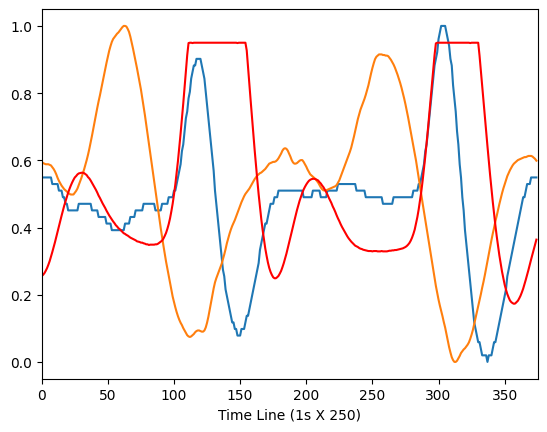

In [ ]:
# 검증 데이터 정의
df_i_test = []
df_t_test = []

list_p = [22]
for i in list_p:
    PPG_data_path = '/content/gdrive/MyDrive/ppg_data/' + str(i) + '/ppg_' + str(i) + '_' + '250' + 'g.txt'

    PPG_data = pd.read_csv(PPG_data_path)
    PPG_data = pd.DataFrame(PPG_data.iloc[47800:48175,1])/1000
    PPG_data = np.array(PPG_data).reshape(-1)
    df_i_test.append(PPG_data)

for i in list_p:
    PPG_data_path = '/content/gdrive/MyDrive/ppg_data/' + str(i) + '/ppg_' + str(i) + '_' + '250' + 'g.txt'

    PPG_data = pd.read_csv(PPG_data_path)
    PPG_data = pd.DataFrame(PPG_data.iloc[47800:48175,2])/1000
    PPG_data = np.array(PPG_data).reshape(-1)
    df_t_test.append(PPG_data)

df_i_test = np.array(df_i_test)

df_i_test = df_i_test.reshape(-1,1)
test_input_data = torch.tensor(cal_fft(df_i_test[:,0]))


# 모델 예측
model.eval()
with torch.no_grad():
    test_output = model(test_input_data.unsqueeze(0))

# 결과 출력
print("Test Input Data:")
print(test_input_data)
print("Predicted Output:")
print(test_output.squeeze())

# 결과 플롯팅
plt.xlim(0,375)
plt.xlabel('Time Line (1s X 250)')
plt.plot(cal_ifft(test_input_data))
plt.plot(cal_ifft(test_output.squeeze()))
plt.plot(df_t_test[0], color = 'r')
plt.savefig("temp", dpi=300)
plt.show

In [ ]:
# 심박수 호흡수 출력 함수 정의
def cal_rate(x):
    N = 375  # 샘플링 개수
    fs = 250  # 샘플링 주파수
    time = np.arange(N)/fs # 시간

    # 심박 관련 주파수 대역 계산
    pulse_freq_range = [0.67, 3.33]  # 대역 범위
    idx_min_p = int(np.floor(pulse_freq_range[0] * N / fs))  # 최소 주파수에 해당하는 FFT 인덱스
    idx_max_p = int(np.ceil(pulse_freq_range[1] * N / fs))  # 최대 주파수에 해당하는 FFT 인덱스

    # 호흡 관련 주파수 대역 계산
    resp_freq_range = [0.13, 0.33]  # 대역 범위
    idx_min_r = int(np.floor(resp_freq_range[0] * N / fs))  # 최소 주파수에 해당하는 FFT 인덱스
    idx_max_r = int(np.ceil(resp_freq_range[1] * N / fs))  # 최대 주파수에 해당하는 FFT 인덱스

    # 심박 IFFT 계산
    fft = np.fft.fft(x)
    fft[:idx_min_p] = 0  # 주파수 대역 이외의 FFT 계수는 0으로 설정
    fft[idx_max_p+1:] = 0
    pulse_filtered = np.real(np.fft.ifft(fft))  # IFFT 계산 후 실수 부분만 추출

    # 호흡 IFFT 계산
    fft1 = np.fft.fft(x)
    fft1[0]=0
    fft1[0:idx_min_r] = 0  # 주파수 대역 이외의 FFT 계수는 0으로 설정
    fft1[idx_max_r+1:] = 0
    resp_filtered1 = np.real(np.fft.ifft(fft1))  # IFFT 계산 후 실수 부분만 추출

    # 심박수 계산
    peak_indices, _ = find_peaks(pulse_filtered, height = 0.1, distance=100)
    peak_times = time[peak_indices]

    pp_intervals = np.diff(peak_times)
    bpm_p = 60 / pp_intervals.mean()
    print("분당 심박수: ", bpm_p)

    # 호흡수 계산
    peak_indices1, _ = find_peaks(resp_filtered1)
    peak_times = time[peak_indices]
    inv_resp_filtered1 = resp_filtered1*(-1)
    peak_indices2, _ = find_peaks(inv_resp_filtered1)
    rr_intervals = np.abs(peak_indices2 - peak_indices1)
    bpm_r = float(60 / rr_intervals)
    print("분당 호흡수: ", bpm_r*60)

    # 결과 출력
    plt.plot(x, label='Original PPG Signal')
    plt.plot(pulse_filtered, label='Pulse Signal')
    plt.plot(resp_filtered1*5, label='Respiration Signal')
    plt.xlim(0, 375)
    plt.xlabel('Time Line (1s X 250)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig("temp", dpi=300)
    plt.show()

<ipython-input-4-60bebde44bf5>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


분당 심박수:  90.36144578313254
분당 호흡수:  19.148936170212767


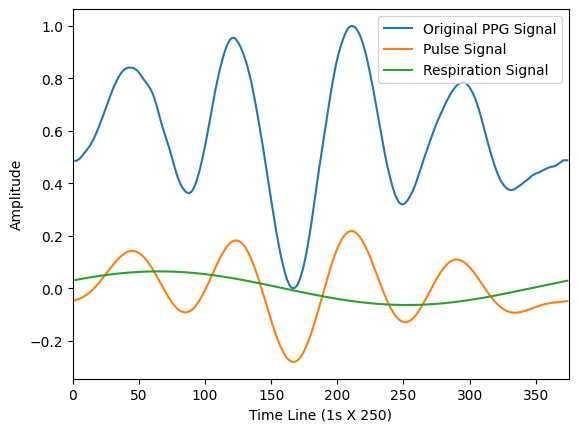

In [ ]:
# 예측 PPG 신호의 분당 심박수 & 호흡수 출력
cal_rate(cal_ifft(test_output.squeeze()).reshape(-1))

분당 심박수:  82.87292817679558
분당 호흡수:  19.148936170212767


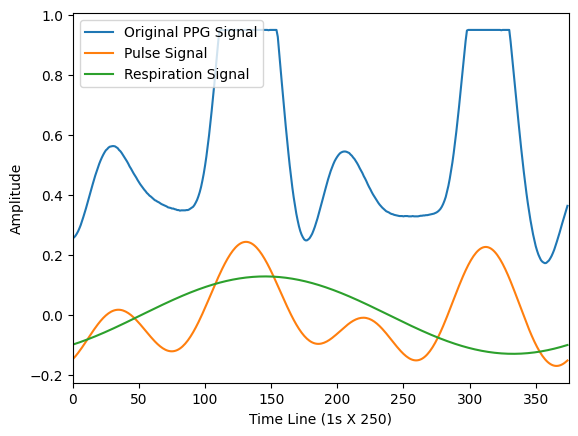

In [ ]:
# 동시간 적정 압력 PPG 신호의 분당 심박수 & 호흡수 출력
cal_rate(df_t_test[0].reshape(-1))

[0.107 0.111 0.117 0.126 0.136 0.149 0.163 0.18  0.198 0.216 0.236 0.256
 0.277 0.296 0.317 0.337 0.356 0.376 0.393 0.411 0.426 0.44  0.453 0.465
 0.475 0.484 0.489 0.495 0.499 0.501 0.502 0.502 0.501 0.497 0.493 0.485
 0.48  0.472 0.463 0.454 0.445 0.436 0.426 0.414 0.405 0.395 0.385 0.376
 0.367 0.356 0.347 0.338 0.331 0.323 0.315 0.309 0.301 0.296 0.29  0.286
 0.281 0.275 0.27  0.268 0.264 0.261 0.257 0.254 0.251 0.248 0.246 0.243
 0.239 0.238 0.237 0.234 0.234 0.232 0.23  0.228 0.228 0.225 0.227 0.227
 0.227 0.227 0.228 0.228 0.23  0.234 0.238 0.242 0.25  0.26  0.272 0.287
 0.305 0.327 0.354 0.384 0.418 0.457 0.501 0.547 0.598 0.653 0.709 0.767
 0.829 0.891 0.952 1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.97
 0.907 0.842 0.776 0.712 0.649 0.588 0.529 0.474 0.42  0.371 

<function matplotlib.pyplot.show(close=None, block=None)>

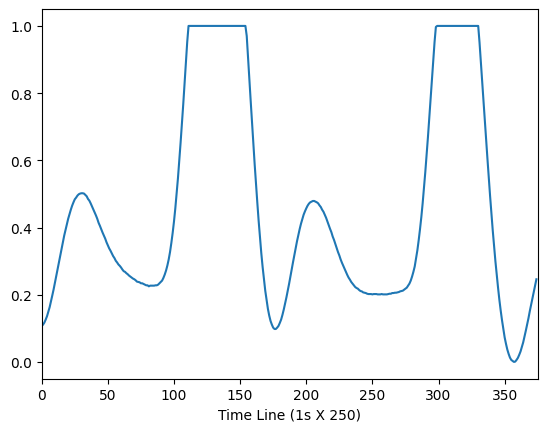

In [ ]:
sample = df_t_test[0].reshape(-1)
sample = sample - np.min(sample)
sample = sample / np.max(sample)
sample = np.round(sample, 3)
for i in range(len(sample)):
  if sample[i] == 0.999:
    sample[i] = 1
print(sample)
plt.xlim(0,375)
plt.xlabel('Time Line (1s X 250)')
plt.plot(sample)
plt.show